<a href="https://colab.research.google.com/github/nirmit27/ds-and-ml/blob/main/Models/transaction-fraud-predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transaction Fraud Prediction**

## Importing the necessary libraries

In [1]:
import os
import joblib

import numpy as np
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier as DTC

from sklearn.metrics import classification_report, accuracy_score

#### Settings for the graphs

In [2]:
plt.style.use("seaborn-v0_8")

#### Suppressing warnings

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing the dataset

In [6]:
df = pd.read_csv(r'/content/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Data Cleaning

### Missing Value Imputation
Checking the dataset for any missing values

In [11]:
df.isna().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


#### Observation
This dataset's features do **not** have any missing values that need imputation.

### Treating Outliers
Removing **outliers** from the numerical features

In [12]:
num_cols = [col for col in df.columns if df[col].dtype != 'object']
num_cols[:]

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [13]:
df[num_cols[1:-2]].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


#### BOXPLOTS

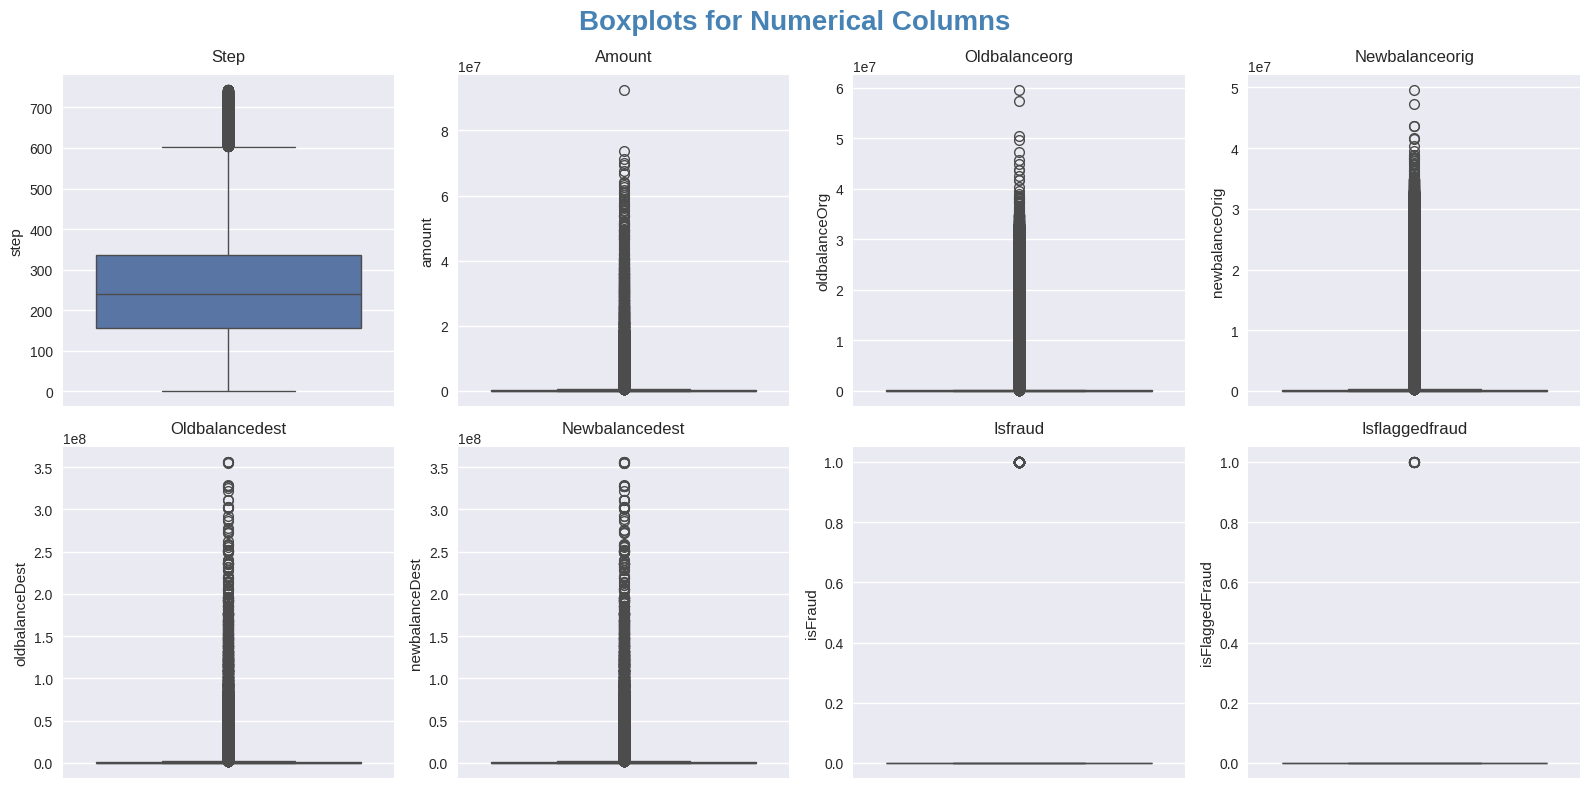

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
fig.suptitle("Boxplots for Numerical Columns", fontsize=20, fontweight='bold', color='steelblue')

for i in range(len(num_cols)):
    sns.boxplot(y=df[num_cols[i]], ax=axs.flatten()[i])
    axs.flatten()[i].set_title(num_cols[i].title(), pad=10)
    # axs.flatten()[i].set_xticks([])

plt.tight_layout()
plt.show()

#### Observation
There are lots of outliers in the numerical features, **but we cannot ignore them** since our problem statement is to distinguish the ***fraudulent*** transactions from the ***non-fraudulent*** transactions, which requires the special consideration of transactions that deal with **extremely high amounts of money** (for instance, above `200,000.00`) in comparison to the amount of money within the 50th or 75th percentile.

**Consider the output of the code cell below :**

In [23]:
mask = (df['isFlaggedFraud'] == 1) & (df.amount > 200000.00) & (df.isFraud == 1)
df[mask][num_cols[1:-2]]

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2736446,4953893.08,4953893.08,4953893.08,0.0,0.0
3247297,1343002.08,1343002.08,1343002.08,0.0,0.0
3760288,536624.41,536624.41,536624.41,0.0,0.0
5563713,4892193.09,4892193.09,4892193.09,0.0,0.0
5996407,10000000.00,19585040.37,19585040.37,0.0,0.0
5996409,9585040.37,19585040.37,19585040.37,0.0,0.0
6168499,3576297.10,3576297.10,3576297.10,0.0,0.0
6205439,353874.22,353874.22,353874.22,0.0,0.0
6266413,2542664.27,2542664.27,2542664.27,0.0,0.0
6281482,10000000.00,10399045.08,10399045.08,0.0,0.0


As we can see, the **fraudulent** transactions involving an `amount` value **greater than 200000.00** have been successfully marked as `1` and hence, these values **should not** be capped by winsorization or any other outlier treatment techniques.

### Multicollinearity
Checking the numerical columns for eliminating **multicollinearity** using **Variance Inflation Factor**

#### HEATMAP

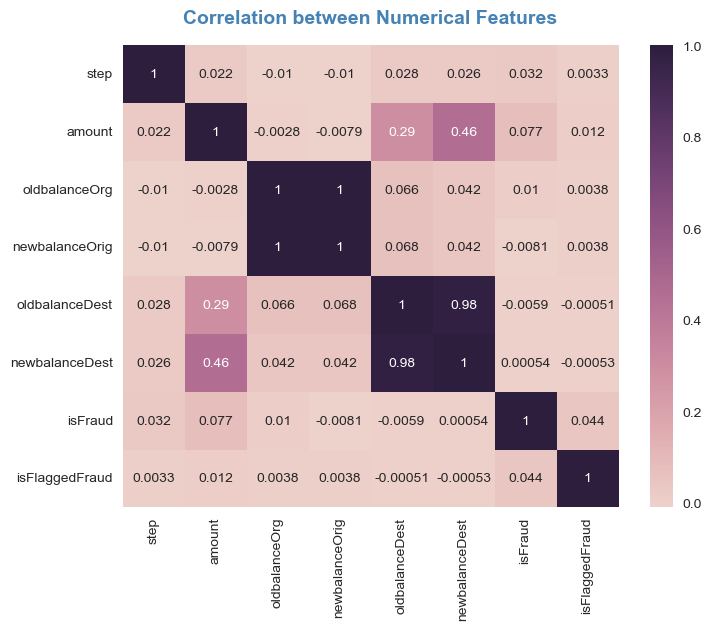

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Correlation between Numerical Features", fontsize=14, fontweight='bold', color='steelblue', pad=16)

sns.heatmap(df[num_cols].corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

#### Observations
1. There is a **strong positive** correlation between `newbalanceDest` and `oldbalanceDest`.
   
2. There is a **strong positive** correlation between `newbalanceOrig` and `oldbalanceOrg`.

3. There is some **positive** correlation between `amount` and `newbalanceDest`.

#### Computing VIF values

In [24]:
def find_vif(cols):
    print("Variance Inflation Factors of Numerical Columns -\n")
    for i in range(df[cols].shape[1]):
        vif_value = vif(df[cols], i)
        print(f"{cols[i].title()} : {vif_value}")

In [25]:
find_vif(num_cols)

Variance Inflation Factors of Numerical Columns -

Step : 1.1910935708661283
Amount : 4.078951905253351
Oldbalanceorg : 544.0531028289049
Newbalanceorig : 546.3460079624596
Oldbalancedest : 72.89552215169822
Newbalancedest : 84.58461924348019
Isfraud : 1.188385501766289
Isflaggedfraud : 1.0025461544077152


#### Correlation
Finding out the correlation between the target column **isFraud** and the other features

In [26]:
col_mask = (~df.columns.isin(['type', 'nameDest', 'nameOrig']))
df.loc[:, col_mask].corr()['isFraud'].sort_values(ascending=False)[1:]

,isFraud
amount,0.076688
isFlaggedFraud,0.044109
step,0.031578
oldbalanceOrg,0.010154
newbalanceDest,0.000535
oldbalanceDest,-0.005885
newbalanceOrig,-0.008148


#### Observation
Here, we can see that `newbalanceOrig` and `oldbalanceDest` have **negative** correlation with the target `isFraud`, so they can be excluded. Thus, we can remove the columns that have **VIF value > 5** to eliminate multicollinearity.

In [27]:
test = [col for col in num_cols if col not in ['newbalanceOrig', 'oldbalanceDest']]
find_vif(test)

Variance Inflation Factors of Numerical Columns -

Step : 1.1608941592772273
Amount : 1.3834185540997297
Oldbalanceorg : 1.0628372534981945
Newbalancedest : 1.403875469754035
Isfraud : 1.0114593566992593
Isflaggedfraud : 1.00206918513641


### Dropping Unnecessary Columns
Removing the unnecessary features from the dataset

In [28]:
df.drop(["newbalanceOrig", "oldbalanceDest", "nameOrig", "nameDest"], axis=1, inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,0.0,0,0


## EDA

### Types of Transactions
Visually depicting the types of transactions in the dataset

In [29]:
t_types = df['type'].value_counts().reset_index()
t_types

,type,count
0,CASH_OUT,2237500
1,PAYMENT,2151495
2,CASH_IN,1399284
3,TRANSFER,532909
4,DEBIT,41432


In [33]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"}, {"type": "pie"}]])

colors = ['steelblue', 'mediumseagreen', 'tomato', 'goldenrod', 'mediumpurple']

fig.add_trace(
    go.Bar(x=t_types['type'], y=t_types['count'], marker_color=colors, showlegend=False),
    row=1, col=1
)
fig.update_xaxes(title_text="Type of transaction", row=1, col=1)
fig.update_yaxes(title_text="Number of Transactions", row=1, col=1)

fig.add_trace(
    go.Pie(values=df['type'].value_counts().values,
           labels=df['type'].value_counts().index,
           hole=0.4),
    row=1, col=2
)

fig.update_layout(
    title_text="Types of Transactions",
    title_font_size=20,
    title_font_color='steelblue',
    title_font_weight='bold',
    showlegend=True,
    legend_title_text="Type of Transaction"
)
fig.show()

#### Observation
Most of the transactions are **cash withdrawals** or **payments** in nature.

## Data Preprocessing

### Categorical to Numerical
Converting the **categorical** values of the `type` feature to **numerical** values

In [34]:
temp = df.copy()
temp.type = temp.type.map(dict(
    zip(
        np.array(df.type.value_counts().index),
        (1, 2, 3, 4, 5),
    )
))

temp.type.value_counts()

,count
type,
1,2237500
2,2151495
3,1399284
4,532909
5,41432


### Dataset Splitting
Splitting the dataset into **features** and **target**

In [35]:
y = np.array(temp[['isFraud']])
X = temp.drop(["step", "isFlaggedFraud"], axis=1)

X_train, X_test, y_train, y_test = tts(
    X, y, train_size=0.8, random_state=42, shuffle=True, stratify=y
)

X_train.shape, X_test.shape

((5090096, 5), (1272524, 5))

## Model Training and Evaluation

### Training
Training a `DecisionTreeClassifier` model

In [36]:
model = DTC()
model.fit(X_train, y_train)

DecisionTreeClassifier()

### Evaluation
Classification report of the model

In [37]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Fraud', 'Not Fraud'])
print(report)

print(f"\nAccuracy : {(accuracy_score(y_test, y_pred) * 100):.2f}%")

              precision    recall  f1-score   support

       Fraud       1.00      1.00      1.00   1270881
   Not Fraud       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524


Accuracy : 100.00%


### Testing
Testing the model from sample inputs from the dataset

#### **Fraudulent** transaction samples

In [38]:
temp[temp['isFraud'] == 1].sample(100).head()

,step,type,amount,oldbalanceOrg,newbalanceDest,isFraud,isFlaggedFraud
3658948,275,4,2607790.58,2607790.58,0.00,1,0
3593088,262,1,68230.32,68230.32,68230.32,1,0
6362500,733,4,1548376.44,1548376.44,0.00,1,0
1070020,122,4,355832.18,355832.18,0.00,1,0
6010951,447,4,219178.49,219178.49,0.00,1,0


#### **Non-fraudulent** transaction samples

In [39]:
temp[temp["isFraud"] == 0].sample(100).head()

,step,type,amount,oldbalanceOrg,newbalanceDest,isFraud,isFlaggedFraud
2902852,228,2,14032.79,0.0,0.00,0,0
4288141,307,3,149683.00,49935.0,173850.68,0,0
288266,15,1,65241.45,0.0,4774560.25,0,0
5508586,380,2,20711.36,141590.0,0.00,0,0
4475551,324,2,13061.61,82431.0,0.00,0,0


In [41]:
def prediction(row_index):
    label = model.predict([temp.loc[row_index, ~temp.columns.isin(["step", "isFlaggedFraud"])].values])[0]
    return "Fraud" if label == 1 else "Not Fraud"

print(prediction(3658948))

Fraud


## Conclusion
The `DecisionTreeClassifier` model trained on the above dataset gives a **100%** accuracy for prediction of fraudulent transactions on the basis of the following features, which are the **key factors** that can help in predicting a fraudulent customer :

1. `type` i.e. the **type** of transaction being made,
   
2. `amount`	i.e. the amount of money being transacted,
   
3. `oldbalanceOrg` i.e. the ***sender*** account's **old balance** and

4. `newbalanceDest` i.e. the ***recipient*** account's **new balance**.

Hence, we can conclude that the company should pay special attention to the above factors associated with **each** transaction.